# Visión Dinámica. Práctica 1

## Flujo Óptico. Método Lucas-Kanade y Horn-Schunck

### 1. ¿Qué es el flujo óptico?
El flujo óptico se refiere al patrón de movimiento aparente de una superficie debido a cambios en la intensidad. Este patrón está relacionado con el movimiento real de los objetos que se representan e, idealmente, representa la proyección 2D del movimiento 3D real.

El flujo óptico se utiliza para describir el movimiento de objetos en una secuencia de imágenes. Existen varios métodos matemáticos para calcular el flujo óptico, pero todos constan de tres etapas básicas:
 1. Prefiltrado (low pass/band pass).
 2. Extracción de medidas (derivadas espacio-temporales, superficies de correlación local, descriptores HOG, SIFT, ...).
 3. Integración de las medidas para producir campo de movimiento 2d (regularización, correlación, mínimos cuadrados, ...).

Para calcular el flujo óptico, se asume que entre dos instantes consecutivos, todo desplazamiento de los niveles de intensidad se debe al vector velocidad que modifica esos niveles. Sin embargo, esto se traduce en una ecuación con dos incógnitas (u y v) que es imposible de resolver.
$$\large I_x + I_v + It = 0 \quad ERFO$$

Este problema se denomina el "problema de la Apertura" (sistema compatible indeterminado). Para resolverlo, se necesita añadir alguna restricción para convertirlo en un sistema compatible determinado.

En esta práctica, se van a desarrollar dos métodos diferentes para resolver este problema:
 - Lucas-Kanade mediante la aproximación de mínimos cuadrados locales.
 - Horn & Schunck mediante el cálculo de regularización global.

Con estos métodos, se pueden calcular las componentes u y v del flujo óptico y, de esta forma, describir el movimiento de los objetos en una secuencia de imágenes de manera más precisa y detallada.

### 2. Método de Lucas-Kanade
Se trata de un método diferencial para estimar el flujo óptico desarrollado por Bruce D. Lucas y Takeo Kanade en 1981. Asume que el flujo es esencialmente constante en la vecindad de un píxel (ventana de integración) y resuelve las ecuaciones básicas de flujo óptico para todos los píxeles vecinos, aplicando el criterio de mínimos cuadrados.

#### 2.1 Implementación de Lucas-Kanade
Este método consta de varios pasos:
 1. Procesado de las imágenes de entrada.
     - $I_x$, $I_y$  $\rightarrow$ Media de filtrado paso alto $(x,y)$ entre $t$ y $t+1$
     - $I_t$  $\rightarrow$ Diferencia entre $I$ en $t$ y $t+1$ (suavizadas) <br>
 2. Sumatorio en vecindades locales** (3x3/5x5/...).
 3. Cálculo de pseudoinversa mediante función pinv() o su desarrollo.
 4. Producto Matricial. $A^-1*b$.

$\;\;\;\;\;\;\;
\begin{bmatrix}  u \\ v \end{bmatrix} =
\begin{bmatrix} \sum I^2_{xi} & \sum I_{xi}I_{yi} \\ \sum I_{xi}I_{yi} & \sum I^2_{yi}  \end{bmatrix} ^{-1}
\begin{bmatrix} -\sum I_{xi}I_{ti} \\-\sum I^2_{yi}I_{ti} \end{bmatrix}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

from typing import List, Tuple

In [2]:
def derivadas(im1: np.ndarray, im2: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    grad_x = (cv2.Sobel(im1, cv2.CV_64F, 1, 0, ksize=3) + cv2.Sobel(im2, cv2.CV_64F, 1, 0, ksize=3)) * 0.5
    grad_y = (cv2.Sobel(im1, cv2.CV_64F, 0, 1, ksize=3) + cv2.Sobel(im2, cv2.CV_64F, 0, 1, ksize=3)) * 0.5

    t = cv2.GaussianBlur(im2, (5, 5), 10) - cv2.GaussianBlur(im1, (5, 5), 10)

    return grad_x, grad_y, t

In [3]:
def lucas_kanade(im1: np.ndarray, im2: np.ndarray, w: int=3, d: bool=True):
    N, M = im1.shape

    Ix, Iy, It = derivadas(im1, im2)

    u, v = np.zeros((N, M)), np.zeros((N, M))

    for y in range(N - (w - 1)):
        for x in range(M - (w - 1)):

            Bx = Ix[y:y+w, x:x+w]
            By = Iy[y:y+w, x:x+w]
            Bt = It[y:y+w, x:x+w]

            a00 = np.sum(Bx * Bx)
            a1 = np.sum(Bx * By)
            a11 = np.sum(By * By)

            b0 = np.sum(Bx * Bt)
            b1 = np.sum(By * Bt)

            if d:
                den = (a00 * a11 - a1 * a1) + 1e-6

                u[y, x] = (-a11 * b0 + a1 * b1) / den
                v[y, x] = (a1 * b0 - a00 * b1) / den

            else:
                A = np.array([[a00, a1],
                              [a1, a11]])

                B = np.array([[-b0],
                              [-b1]])

                U = np.linalg.pinv(A) @ B

                u[y, x] = U[0]
                v[y, x] = U[1]
    return u , v

In [4]:
def map_flow(u: np.ndarray, v: np.ndarray, img: np.ndarray, s: int=8):
    n, m = u.shape

    for y in range(0, n, s):
        for x in range(0, m, s):

            fu = int(1 * np.sum(u[y:y + s, x:x + s]) / (s * s))
            fv = int(1 * np.sum(v[y:y + s, x:x + s]) / (s * s))

            if np.sqrt(fv * fv + fu * fu) > 3:
                cv2.arrowedLine(img, (x, y), (x - fu, y - fv), 255, 1)

    return img

In [5]:
def plot_imgs(images: List[np.array], titles: List[str], title:str = '', size: Tuple = (15, 4)):

    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize= size)
    fig.suptitle(title)

    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [6]:
def plot_uv(u: np.ndarray, v: np.ndarray, im: np.ndarray, quivstep: int=10, title: str=''):
    h, w = im.shape[:2]

    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(title)

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(im, cmap='gray')
    ax2.imshow(np.zeros_like(im, dtype=float), cmap='gray')

    for i in range(quivstep //2 , h + quivstep // 2, quivstep):
        for j in range(quivstep//2, w + quivstep // 2, quivstep):

            u_mean = np.mean(u[i:i + quivstep + 1, j:j + quivstep + 1]) * 10
            v_mean = np.mean(v[i:i + quivstep + 1, j:j + quivstep + 1]) * 10

            if np.sqrt(u_mean ** 2 + v_mean ** 2) < 4:
                continue

            ax1.arrow(j, i, v_mean, u_mean, color='red', head_width=5, head_length=3)
            ax2.arrow(j, i, v_mean, u_mean, color='white', head_width=5, head_length=3)

    ax1.axis('off')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

#### 2.2 Experimentos Lucas-Kanade
Una vez implementado el código se han utilizado la siguiente secuencia de imágenes para probar el método de Lukas Kanade.

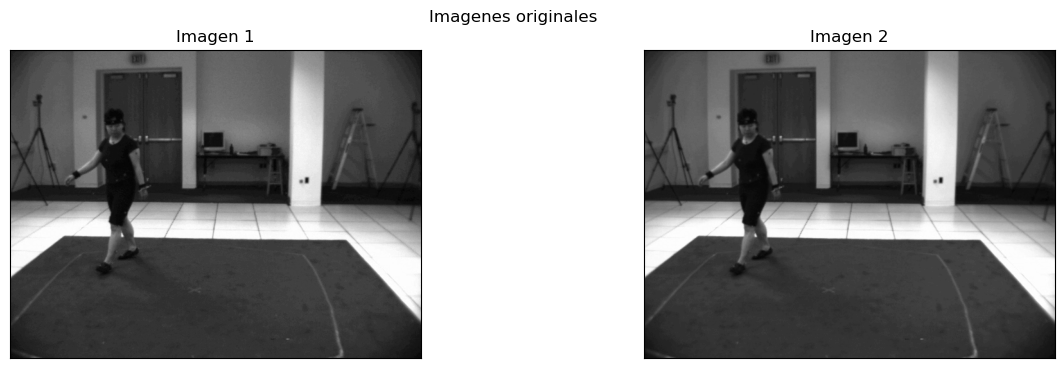

In [7]:
images = [cv2.imread('image/fr00100.png', 0), cv2.imread('image/fr00101.png', 0)]

plot_imgs(images, ['Imagen 1', 'Imagen 2'], 'Imagenes originales')

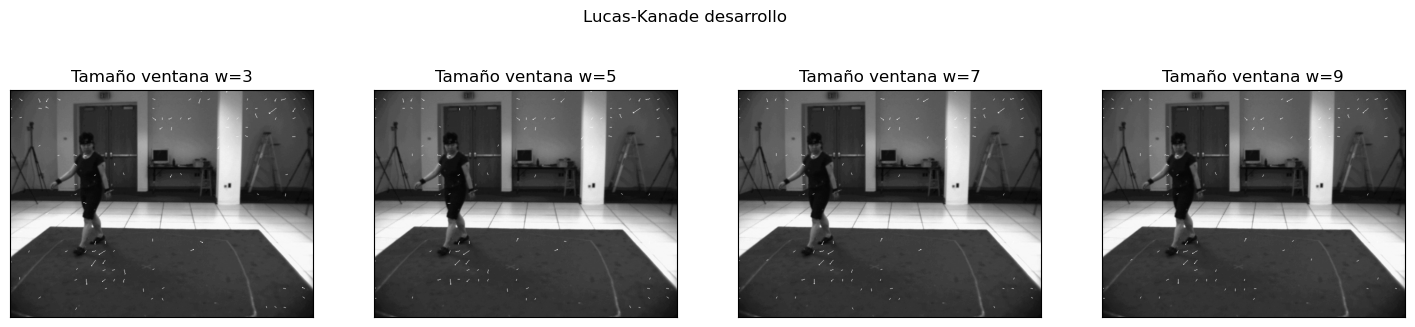

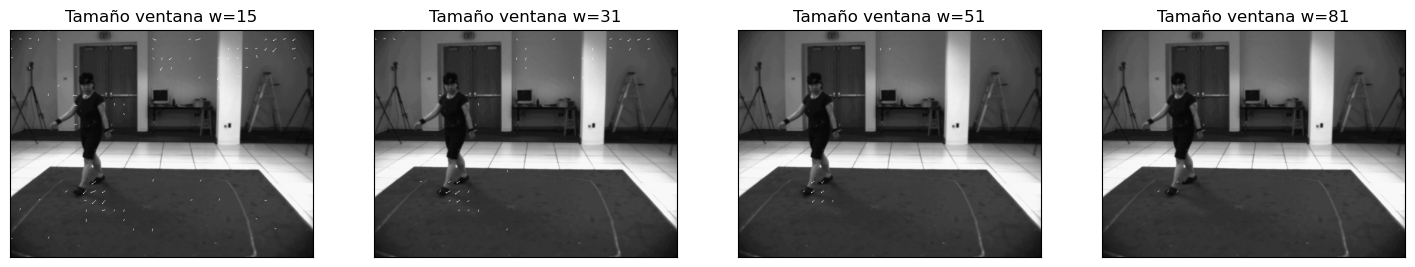

In [8]:
im0, im1 = cv2.imread('image/fr00100.png', 0), cv2.imread('image/fr00101.png', 0)

images = []
titles = []
tiempo_desarrollo = []

kernel_sizes = [3, 5, 7, 9, 15, 31, 51, 81, 101, 201, 301]
for k in kernel_sizes:
    start = time.time()
    u, v = lucas_kanade(im0, im1, k, True)
    tiempo_desarrollo.append(time.time() - start)

    images.append(map_flow(u, v, im1.copy(), 20))
    titles.append(f'Tamaño ventana w={k}')

plot_imgs(images[:4], titles[:4], 'Lucas-Kanade desarrollo', (18, 4))
plot_imgs(images[4:8], titles[4:8], title='', size=(18, 4))

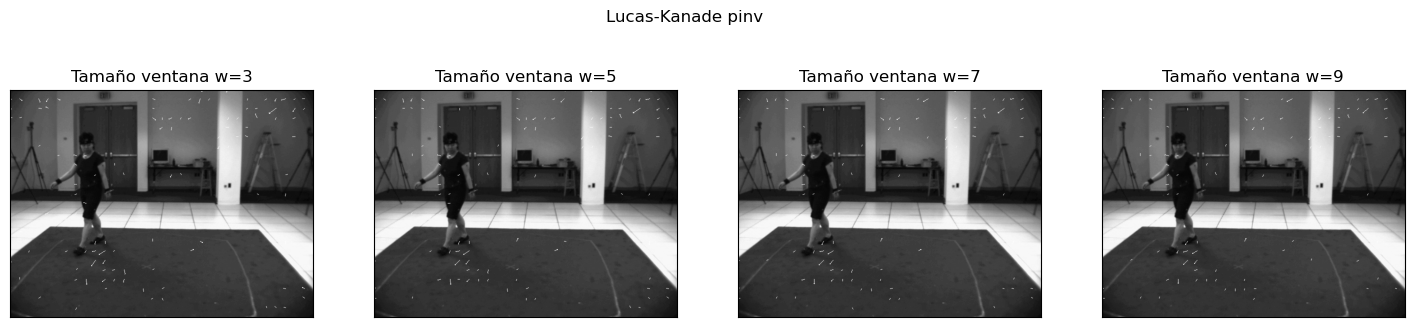

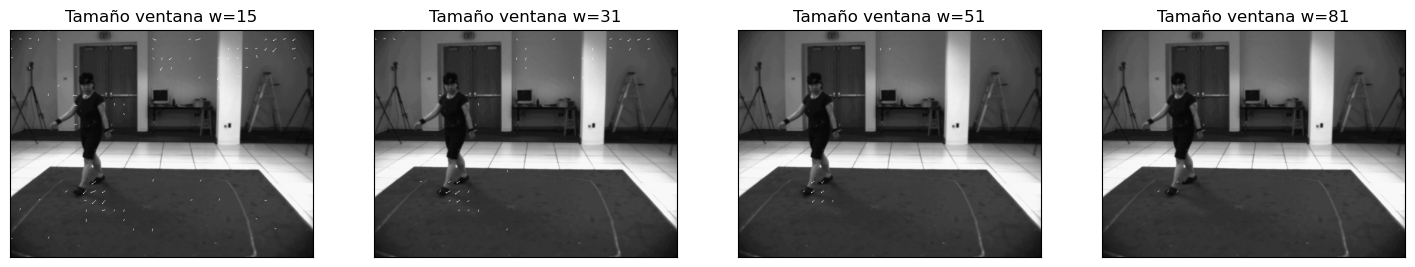

In [9]:
im0, im1 = cv2.imread('image/fr00100.png', 0), cv2.imread('image/fr00101.png', 0)

images = []
titles = []
tiempo_pinv = []

kernel_sizes = [3, 5, 7, 9, 15, 31, 51, 81, 101, 201, 301]

for k in kernel_sizes:
    start = time.time()
    u, v = lucas_kanade(im0, im1, k, False)
    tiempo_pinv.append(time.time() - start)

    images.append(map_flow(u, v, im1.copy(), 20))
    titles.append(f'Tamaño ventana w={k}')

plot_imgs(images[:4], titles[:4], 'Lucas-Kanade pinv', (18, 4))
plot_imgs(images[4:8], titles[4:8], title='', size=(18, 4))

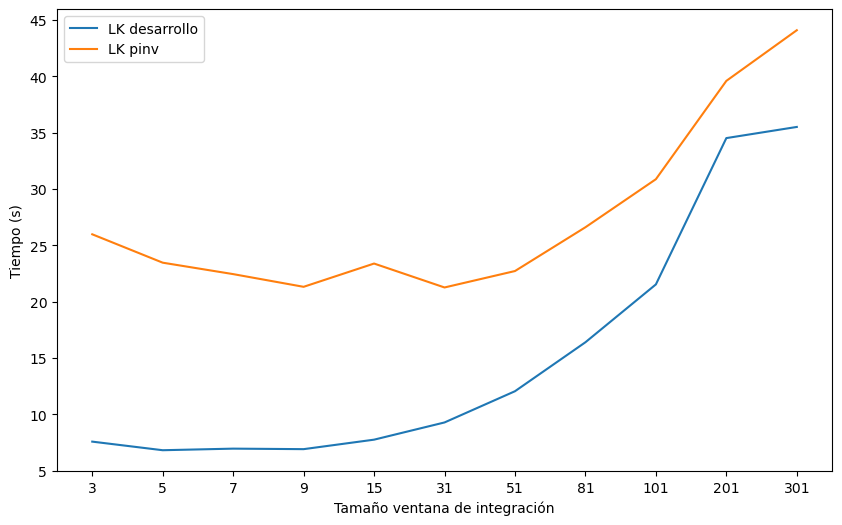

In [10]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
kernel_sizes = [3, 5, 7, 9, 15, 31, 51, 81, 101, 201, 301]
plt.figure(figsize=(10, 6))
plt.plot(x, tiempo_desarrollo, label='LK desarrollo')
plt.plot(x, tiempo_pinv, label='LK pinv')

plt.xticks(x, kernel_sizes)

plt.xlabel('Tamaño ventana de integración')
plt.ylabel('Tiempo (s)')

plt.legend()
plt.show()

#### 2.3 Resultado:
##### 2.3.1 Análisis de tiempo de ejecución
En la gráfica anterior, se compararon los tiempos de ejecución de ambos métodos con diferentes tamaños de ventana de integración. Se destaca que el método Lukas-Kanade desarrollado es casi el doble de rápido, debido a que la operación de invertir matrices (pinv) es mucho más costosa computacionalmente que el producto de Hadamard. Sin embargo, el tamaño de la ventana de integración no tiene un efecto directo hasta que se aumenta su tamaño a números superiores a 51.

##### 2.3.2 Análisis de resultado de la imagen
Se puede destacar que en ambos desarrollos no se aprecia variación en el resultado del flujo óptico, lo cual tiene sentido dado que el método directo es un desarrollo del método de mínimos cuadrados. Sin embargo, se observan cambios cuando se modifica el tamaño de la ventana de integración.

Al aplicar una ventana de integración de menor tamaño, se observa más ruido en el fondo de la imagen, ya que se producen pequeños cambios en la intensidad de los píxeles en la imagen que detecta el método. Esto se comprueba al aumentar la ventana de integración, ya que se observa como el ruido desaparece. Sin embargo, aumentar el tamaño de integración trae consigo otro problema, detectando menos movimiento en la secuencia de la imagen. Incluso en las imágenes finales con ventana de integración de 81, prácticamente no se detecta movimiento.

##### 2.3.3 Conclusión
En conclusión, se puede afirmar que el método de Lukas-Kanade es robusto y eficaz en la detección de movimiento en secuencias de imágenes. Además, el método Lukas-Kanade desarrollado es más rápido que el método directo, pero no afecta al resultado sustancialmente. Sin embargo, es importante seleccionar cuidadosamente el tamaño de la ventana de integración, ya que puede afectar a la precisión y la cantidad de ruido en la imagen.

## Método de Horn and Schunck

### 3. Método de Horn&Schunck
Se trata de un método iterativo que introduce una condición de suavidad global para resolver el problema de apertura. Este método se denomina global porque determina el vector de movimiento del flujo óptico en cada píxel de la imagen, a diferencia de los métodos locales que actúan sobre una ventana de integración concreta.

#### 3.1 Implementación de Horn&Schunck
Este método consta de varias etapas:
1. Se calculan las derivadas espacio-temporales $I_x$, $I_y$, $I_t$ (Igual método anterior)
1. Se inicializan los valores de $u^0(i,j)$ y $v^0(i,j)$
1. Se repiten las ecuaciones iterativas hasta un número máximo de iteraciones. $\lambda$ es un parámetro que actúa como ponderación de ambas magnitudes de error.

In [11]:
def horn_shunck(im_prev: np.array, im_next: np.array, niter: int, lamb: float):
    """
    Horn and Shunck optical flow algorithm.
    :param im_prev: Numpy array First image of the sequence.
    :param im_next: Numpy array Second image of the sequence.
    :param niter: int Number iterations.
    :param lamb: float lambda value.
    :return u, v: Numpy arrays u and v components of the optical flow.
    """

    # Normalize images between 0 and 1
    im0, im1 = im_prev / 255., im_next / 255.

    # Gradients in x and y directions
    fx1, fy1 = np.gradient(im0)
    fx2, fy2 = np.gradient(im1)

    ix = (fx1 + fx2) * .5
    iy = (fy1 + fy2) * .5
    it = im1 - im0

    # Initialize u and v
    u, v = np.zeros_like(im0), np.zeros_like(im0)

    for _ in range(niter):
        u_avg = cv2.blur(u, (3, 3))
        v_avg = cv2.blur(v, (3, 3))

        n = ix * u_avg + iy * v_avg + it
        d = lamb ** 2 + ix ** 2 + iy ** 2
        m = n / d

        u = u_avg - ix * m
        v = v_avg - iy * m

    return u, v

#### 3.2 Experimentos método de Horn-Schunck

El método de Horn-Schunck se trata de un método iterativo, por lo que se ha probado con diferentes número de iteraciones para ver como se comporta. Además, este método introduce el valor de $\lambda$: una constante de regularización que se ha modificado para ver los diferentes resultados.

En la siguiente figura, se puede ver los resultados para 5 iteraciones y el parámetro $\lambda$ desde 0.001 hasta 1.

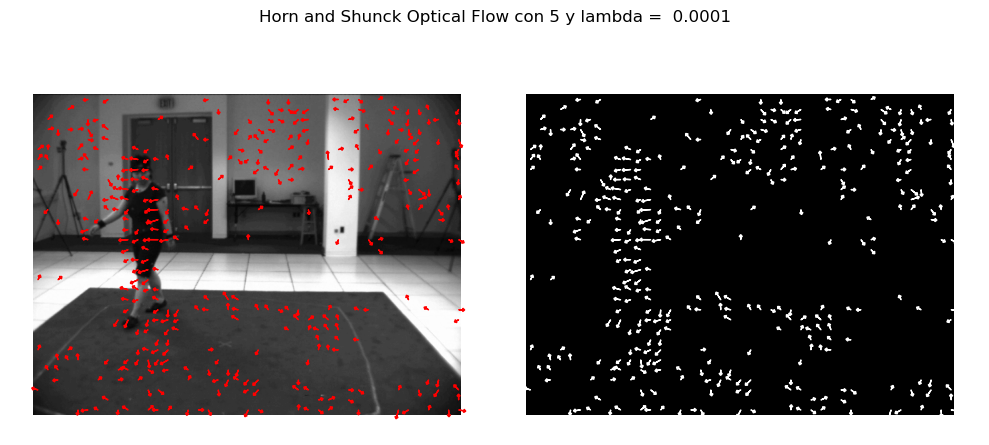

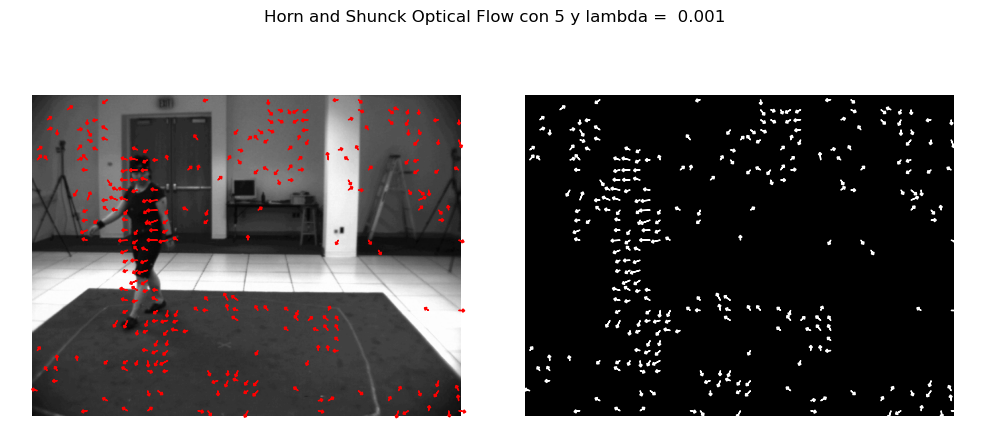

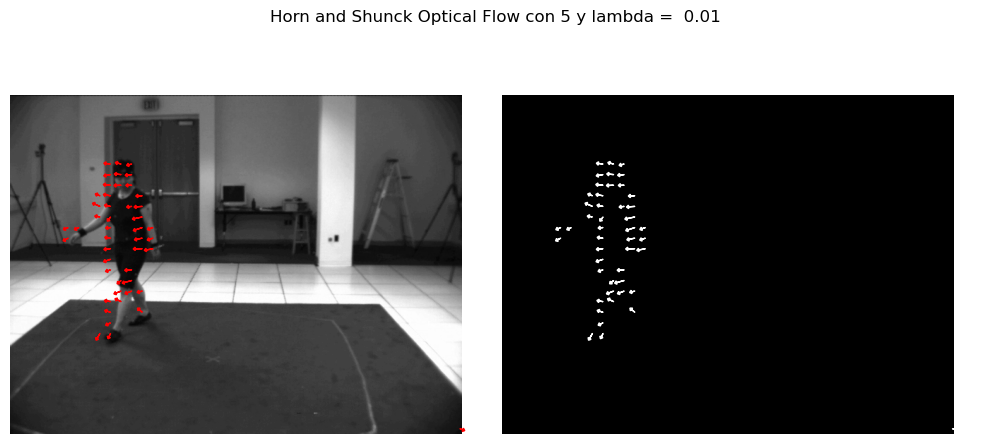

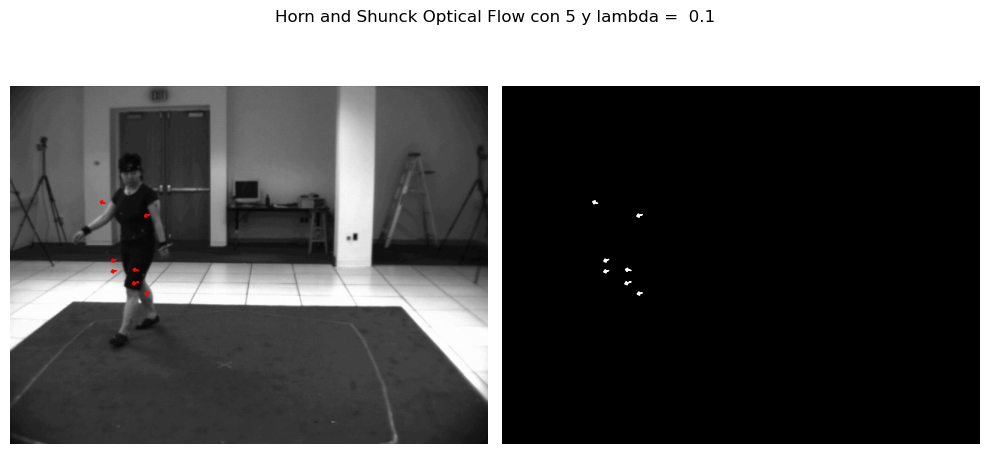

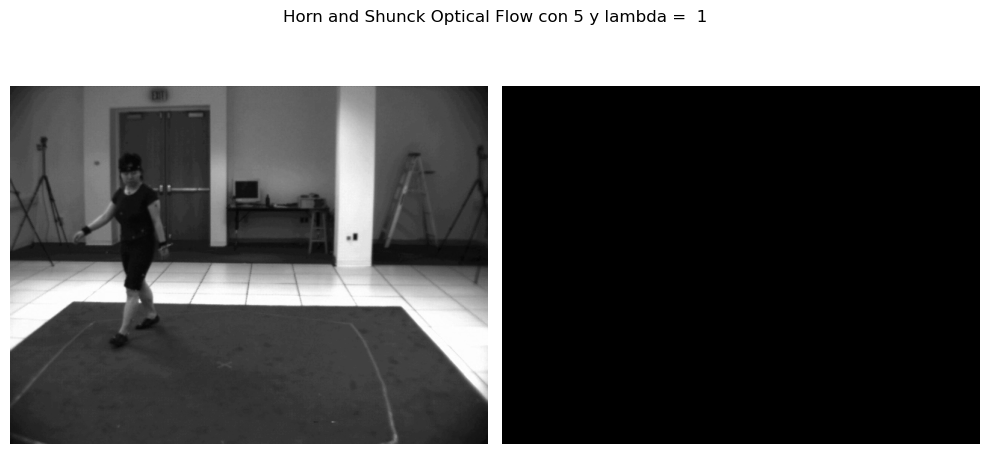

In [12]:
im1, im2 = cv2.imread('image/fr00100.png', 0), cv2.imread('image/fr00101.png', 0)

lambd = [0.0001, 0.001, 0.01, 0.1, 1]
niter = 5

for l in lambd:
    u, v = horn_shunck(im1, im2, niter, l)
    plot_uv(u, v, im2, quivstep=15, title=f"Horn and Shunck Optical Flow con {niter} y lambda =  {str(l)}")

En la siguiente figura, se puede ver los resultados con 10 iteraciones y el parámetro $\lambda$ desde 0.001 hasta 1.

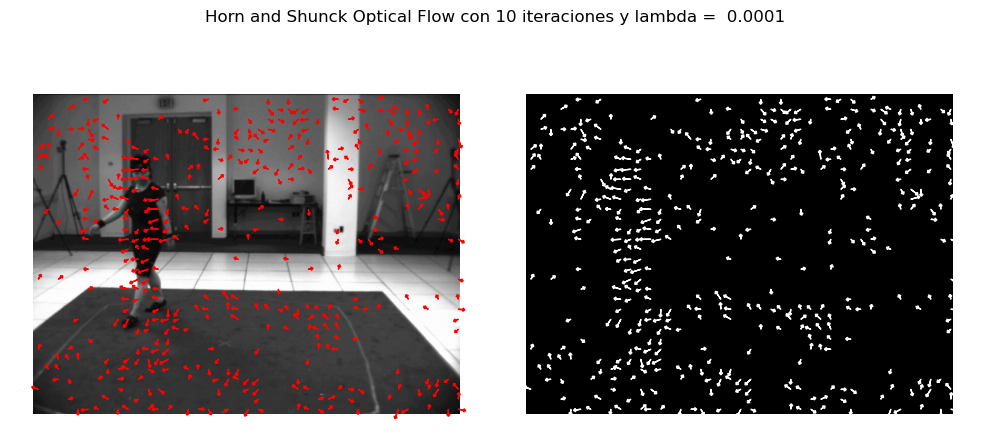

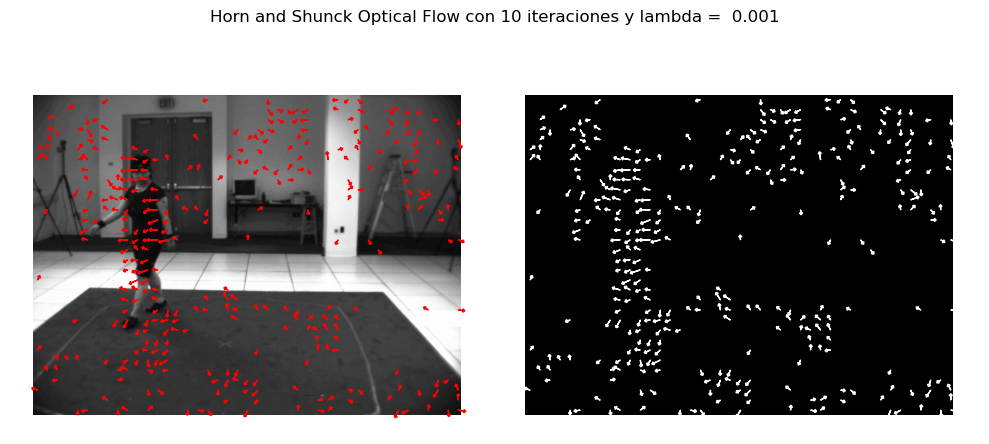

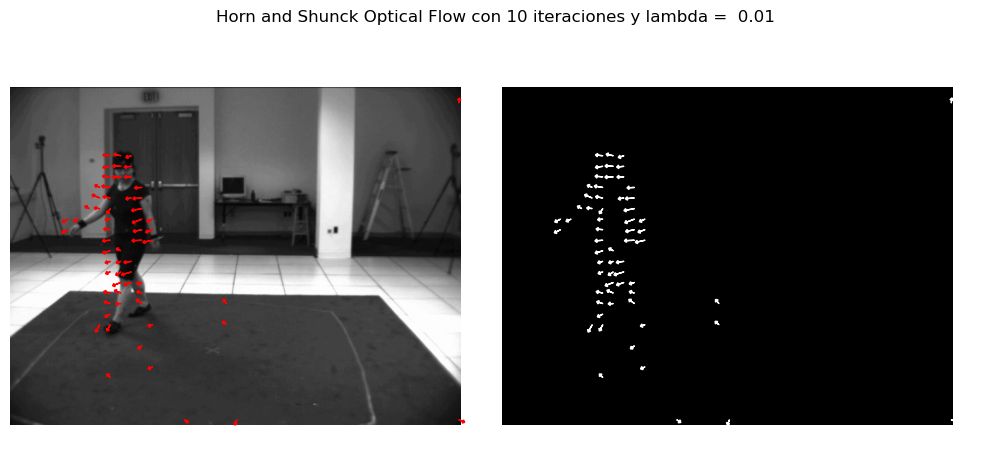

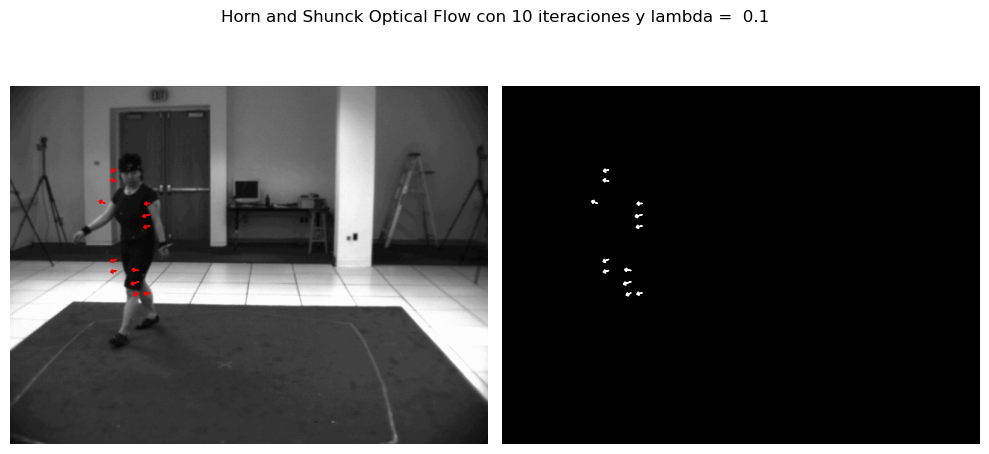

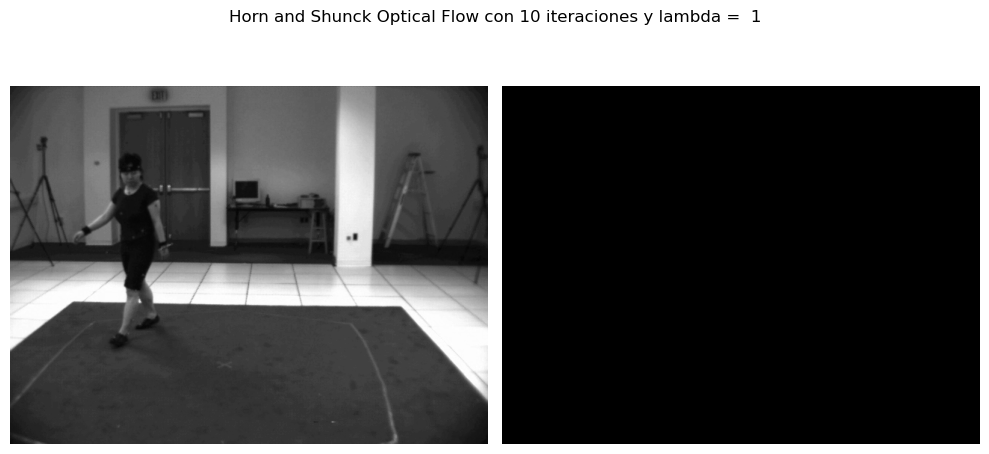

In [13]:
im_1, im_2 = cv2.imread('image/fr00100.png', 0), cv2.imread('image/fr00101.png', 0)

lambd = [0.0001, 0.001, 0.01, 0.1, 1]
niter = 10

for l in lambd:
    u, v = horn_shunck(im_1, im_2, niter, l)
    plot_uv(u, v, im2, quivstep=15, title=f"Horn and Shunck Optical Flow con {niter} iteraciones y lambda =  {str(l)}")

In [14]:
# Analisis de tiempo

t = time.time()
u, v = horn_shunck(im_1, im_2, 10, 0.01)
print(f"El tiempo que tarda en realizar 10 iteraciones el método Horn-Schunck:{(time.time() - t)*10}s")

El tiempo que tarda en realizar 10 iteraciones el método Horn-Schunck:0.6024670600891113s


#### 3.3 Resultado
##### 3.3.1 Análisis de tiempo de ejecución
En este método de flujo óptico, el tiempo de ejecución depende del número de iteraciones. Sin embargo, se ha realizado un análisis y se puede concluir que a partir de 10 iteraciones el error es inferior a 0.001 y no se aprecia cambio alguno en el resultado final de la imagen. Por tanto, se puede obtener un buen resultado con este método en un tiempo de ejecución que ronda los dos segundos.

#### 3.3.2 Analisis de los resultados de la imagen
En las imágenes anteriores, se ha realizado un estudio variando el valor de $\lambda$ y se ha configurado un número de iteraciones de 10 debido a que el error es suficientemente bajo a partir de ese valor.

Se ha observado que al configurar un valor pequeño de $\lambda$, se obtiene una imagen de flujo óptico más ruidosa capaz de detectar cambios de intensidad de píxeles en pequeñas áreas. En cambio, al aumentar el valor de $\lambda$, se reduce el ruido y se puede observar el movimiento de forma más global en la imagen.

#### 3.3.3 Conclusión
El método de Horn-Schunck es también un método eficaz y robusto para el cálculo del flujo óptico, y se puede obtener un buen resultado con un tiempo de ejecución razonable al configurar un número adecuado de iteraciones. Igualmente, es importante seleccionar cuidadosamente el valor de $\lambda$ para encontrar un buen resultado.

### 4 Conclusión
En general, se puede concluir que ambos métodos de flujo óptico son eficaces en la detección de movimiento en secuencias de imágenes, pero presentan diferencias en su rendimiento y precisión. El método de Horn&Shunck es más rápido, pero su tiempo de ejecución depende del número de iteraciones, aunque se puede obtener un buen resultado con un tiempo razonable. Por otro lado, el método de Lukas-Kanade es más lento en ambos desarrollos y el tamaño de la ventana de integración puede afectar la precisión y la cantidad de ruido en la imagen. En ambos casos, es importante seleccionar adecuadamente los parámetros del método para lograr un equilibrio adecuado entre precisión y velocidad.

### 5 Otras
#### 5.1 Esfera

/home/pablo/miniconda3/envs/cv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pablo/miniconda3/envs/cv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


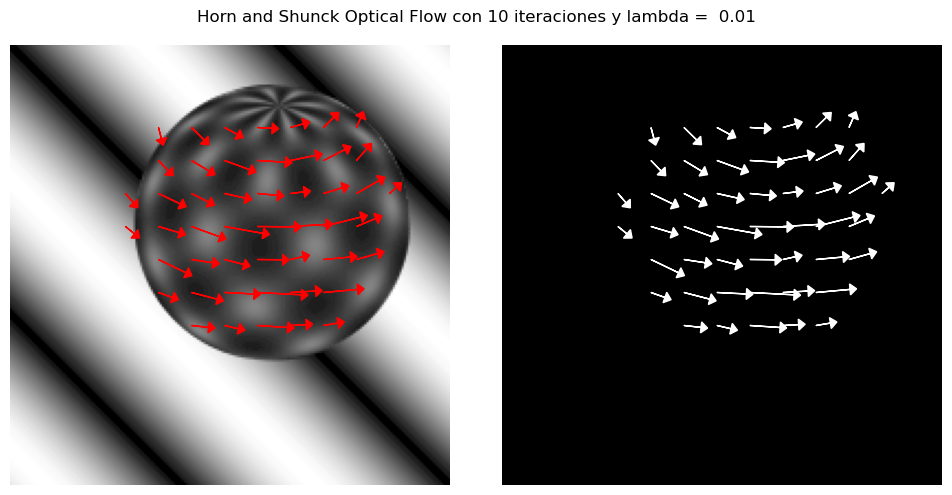

In [15]:
im1, im2 = cv2.imread('image/sphere_0.png', 0), cv2.imread('image/sphere_1.png', 0)

l, niter = 0.01, 10

u, v = horn_shunck(im1, im2, niter, l);
plot_uv(u, v, im2, quivstep=15, title=f"Horn and Shunck Optical Flow con {niter} iteraciones y lambda =  {str(l)}")

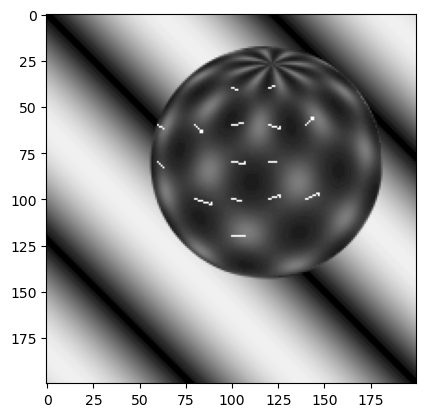

In [16]:
im1, im2 = cv2.imread('image/sphere_0.png', 0), cv2.imread('image/sphere_1.png', 0)

kernel = 7

u, v = lucas_kanade(im1, im2, kernel, True)
plt.imshow(map_flow(u, v, im1.copy(), 20), cmap="gray")

#### 5.2 Basketball

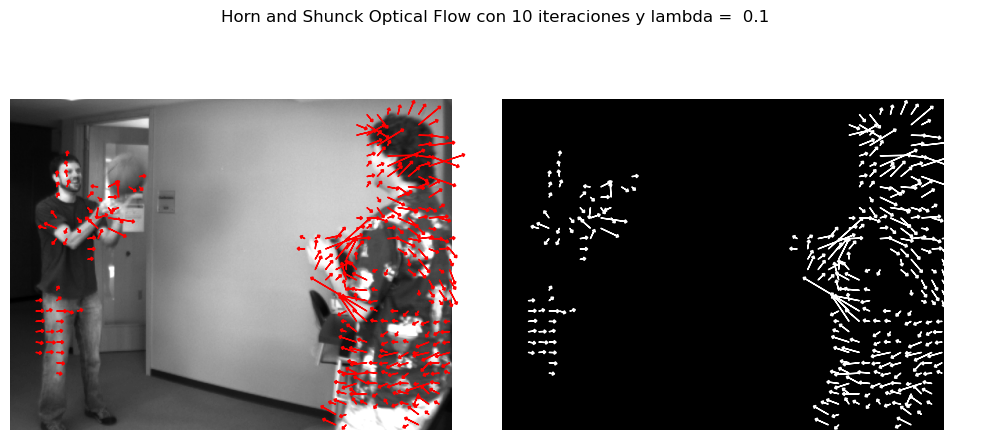

In [17]:
im1, im2 = cv2.imread('image/basketball1.png', 0), cv2.imread('image/basketball2.png', 0)

l = 0.1
niter = 10

u, v = horn_shunck(im1, im2, niter, l);
plot_uv(u, v, im2, quivstep=15, title=f"Horn and Shunck Optical Flow con {niter} iteraciones y lambda =  {str(l)}")

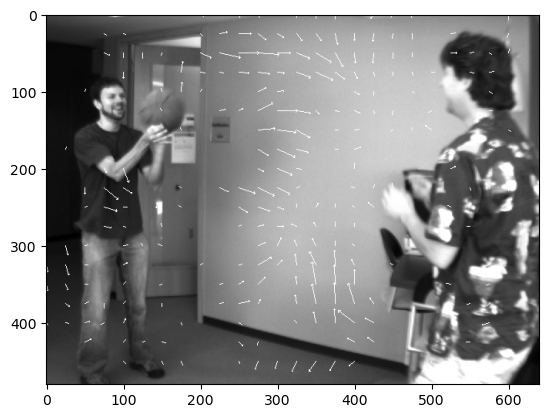

In [18]:
im1, im2 = cv2.imread('image/basketball1.png', 0), cv2.imread('image/basketball2.png', 0)

kernel = 7

u, v = lucas_kanade(im1, im2, kernel, True)
plt.imshow(map_flow(u, v, im1.copy(), 25), cmap="gray")